In [ ]:
# !pip3 install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu124
# !pip install matplotlib==3.9.0
# !pip install numpy==2.0.0
# !pip install opencv-python==4.10.0.84
# !pip install tqdm==4.66.4

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import os
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from IPython import display



In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        return image, 0

def load_images_from_folder(folderm, max_imgs=None):
    images = []
    files = os.listdir(folderm) if max_imgs is None else os.listdir(folderm)[:max_imgs]
    for filename in files:
        img = cv2.imread(os.path.join(folderm, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
    return np.array(images)

In [2]:

class DiffusionModel():
    def __init__(self, model, timesteps=1000, beta_start=1e-4, beta_end=0.02, img_size=64, device=None):
        self.model = model
        self.timesteps = timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device if device is not None else torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.beta = self.linear_beta_schedule()
        self.alpha = (1. - self.beta)
        self.alphas_cumprod = torch.cumprod(self.alpha, dim=0)

    def linear_beta_schedule(self, beta_start=None, beta_end=None, timesteps=None):
        beta_start = beta_start if beta_start is not None else self.beta_start
        beta_end = beta_end if beta_end is not None else self.beta_end
        timesteps = timesteps if timesteps is not None else self.timesteps

        return torch.linspace(beta_start, beta_end, timesteps, device=self.device)
    
    
    def forward_diffusion_sample(self, x0, t): # add nois to image
        noise = torch.randn_like(x0)
        sqrt_alpha_cumprod = torch.sqrt(self.alphas_cumprod[t])[:, None, None, None]
        sqrt_one_minus_alpha_cumprod = torch.sqrt(1.0 - self.alphas_cumprod[t])[:, None, None, None]
        return sqrt_alpha_cumprod * x0 + sqrt_one_minus_alpha_cumprod * noise, noise
    

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.timesteps, size=(n,))
    
    # Original implementation https://github.com/dome272/Diffusion-Models-pytorch/blob/be352208d0576039fec061238c0e4385a562a2d4/ddpm.py#L39

    # /* 
    #  * Copyright 2024, dome272
    #  * Licensed under the Apache License, Version 2.0 (the "License");
    #  * you may not use this file except in compliance with the License.
    #  * You may obtain a copy of the License at
    #  * 
    #  * http://www.apache.org/licenses/LICENSE-2.0
    #  * 
    #  * Unless required by applicable law or agreed to in writing, software
    #  * distributed under the License is distributed on an "AS IS" BASIS,
    #  * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
    #  * See the License for the specific language governing permissions and
    #  * limitations under the License.
    #  */

    def sample(self, n): # model  => unet
        self.model.eval()
        with torch.no_grad():
            x = torch.randn((n, 3, self.img_size, self.img_size), device=self.device)
            for i in tqdm(reversed(range(1, self.timesteps)), position=0):
                t = (torch.ones(n, device= self.device) * i).long() # time encode
                predicted_noise = self.model(x, t)
                alpha = self.alpha[t][:, None, None, None]
                alphas_cumprod = self.alphas_cumprod[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alphas_cumprod))) * predicted_noise) + torch.sqrt(beta) * noise
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        return x

In [3]:
# Original implementation  https://github.com/dome272/Diffusion-Models-pytorch/blob/main/modules.py

# /* 
#  * Copyright 2024, dome272
#  * Licensed under the Apache License, Version 2.0 (the "License");
#  * you may not use this file except in compliance with the License.
#  * You may obtain a copy of the License at
#  * 
#  * http://www.apache.org/licenses/LICENSE-2.0
#  * 
#  * Unless required by applicable law or agreed to in writing, software
#  * distributed under the License is distributed on an "AS IS" BASIS,
#  * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  * See the License for the specific language governing permissions and
#  * limitations under the License.
#  */

# Modifications made by Ignacio2M on 25/6/24.

# Utils layers
# ---------------------------------------------------------------- ConvBlock ---------------------------------------------------------------- 
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super(ConvBlock, self).__init__()
        self.residual = residual

        mid_channels = mid_channels if mid_channels is not None else out_channels
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.conv(x))
        else:
            return self.conv(x)
        

# ---------------------------------------------------------------- DownsampleBlock ---------------------------------------------------------------- 
class DownsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dime=256):
        super(DownsampleBlock, self).__init__()

        self.downSmaple = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, in_channels, residual=True), 
            ConvBlock(in_channels, out_channels),
        )



        self.embedding = nn.Sequential(
            nn.Linear(emb_dime, out_channels),
            nn.SiLU()
        )

    def forward(self, x, t):
        x = self.downSmaple(x)
        emb = self.embedding(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb

# ---------------------------------------------------------------- DownsampSelfAttentionBlockleBlock ---------------------------------------------------------------- 
class SelfAttentionBlock(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttentionBlock, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)
    

    
# ---------------------------------------------------------------- UpsampleBlock ---------------------------------------------------------------- 
class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dime=256):
        super(UpsampleBlock, self).__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            ConvBlock(in_channels, in_channels, residual=True),
            ConvBlock(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dime,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, image_size=64, device=None):
        super().__init__()
        self.device =  device if device is not None else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.time_dim = time_dim
        self.inc = ConvBlock(c_in, 64)
        self.down1 = DownsampleBlock(64, 128, emb_dime=time_dim)
        self.sa1 = SelfAttentionBlock(128, image_size//2) #imageSize / 2
        self.down2 = DownsampleBlock(128, 256, emb_dime=time_dim)
        self.sa2 = SelfAttentionBlock(256, image_size//4) #imageSize / 4
        self.down3 = DownsampleBlock(256, 256, emb_dime=time_dim)
        self.sa3 = SelfAttentionBlock(256, image_size//8) #imageSize / 8

        self.bot1 = ConvBlock(256, 512)
        self.bot2 = ConvBlock(512, 512)
        self.bot3 = ConvBlock(512, 256)

        self.up1 = UpsampleBlock(512, 128, emb_dime=time_dim)
        self.sa4 = SelfAttentionBlock(128, image_size//4) #imageSize / 4
        self.up2 = UpsampleBlock(256, 64, emb_dime=time_dim)
        self.sa5 = SelfAttentionBlock(64, image_size//2) #imageSize / 2
        self.up3 = UpsampleBlock(128, 64, emb_dime=time_dim)
        self.sa6 = SelfAttentionBlock(64, image_size) # imageSize
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output

In [5]:
# import os
import configparser
# import torch
from datetime import date

class CheckpointManager:
    def __init__(self, checkpoint_path, continue_count=False) -> None:
        self.checkpoint_path_dir = checkpoint_path
        self.config_file = os.path.join(self.checkpoint_path_dir, 'checkpoint')
        self.config = configparser.ConfigParser()
        self.continue_count = continue_count

        self.start_epoch = 0

        self._initHistory()
    
    def _initHistory(self):
        if not os.path.exists(self.checkpoint_path_dir):
            os.makedirs(self.checkpoint_path_dir)

        if not os.path.exists(self.config_file):
            self.config["DEFAULT"] = {"startEpoc": 0}
            with open(self.config_file, 'w') as configfile:
                self.config.write(configfile)



    def save_checkpoint(self, state, epoch, format='pth.tar'):
        file_name = f'checkpoint-{epoch+self.start_epoch}.{format}'
        file_path = os.path.join(self.checkpoint_path_dir, file_name)
        torch.save(state, file_path)
        self.config["save.last"] = {
            "SaveDate":  date.today(),
            "CheckpointName": file_name
        }

        with open(self.config_file, 'w') as configfile:
                self.config.write(configfile)

        
    def load_checkpoint(self, model, optimizer, file_name=None):

        if not file_name:
            self.config.read(self.config_file)
            file_name = self.config["save.last"]["CheckpointName"]
            if not file_name: 
                file_name = "NoName"
                
        file_path = os.path.join(self.checkpoint_path_dir, file_name)

        if os.path.isfile(file_path):
            print(f"=> Loading checkpoint '{file_name}'")
            checkpoint = torch.load(file_path)
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            epoch = checkpoint['epoch']
            loss = checkpoint['loss']
            print(f"=> Loaded checkpoint '{file_name}' (epoch {epoch})")

            if self.continue_count:
                self.start_epoch = epoch
                print(f"continue from epoch: {self.start_epoch}")

            return epoch, loss
        else:
            print(f"=> No checkpoint found at '{file_path}'")
            return 0, None

In [6]:
def sowSample(samples, save_name=None):
    # expected shape -> [mum_images, len_color(RGB), height, width]
    images = samples.permute(0, 2, 3, 1) # [N, D, H, W] -> [N, H, W, D]
    if type(images) == torch.Tensor and images.device.type != "cpu":
        images = images.to('cpu')
    for i in range(min(images.shape[0], 4)):
        plt.subplot(2,2, i+1)
        # print(predictions[i, :, :, :])
        plt.imshow(images[i, :, :, :])
        plt.axis('off')
    plt.show()
    if save_name:
        vutils.save_image(samples[:min(samples.shape[0], 4), :, :, :], f'{save_name}.png', normalize=True)

In [7]:
def compareResults(realImage, noise, noise_img, result):
    realImage = realImage.permute(0, 2, 3, 1) # [N, D, H, W] -> [N, H, W, D]
    
    realImage = realImage[0, :, :, :]
    realImage = (realImage + 1) / 2
    if type(realImage) == torch.Tensor and realImage.device.type != "cpu":
        realImage = realImage.to('cpu')
    

    noise = noise.permute(0, 2, 3, 1) # [N, D, H, W] -> [N, H, W, D]
    noise = noise[0, :, :, :]
    noise = (noise-torch.min(noise))/(torch.max(noise)-torch.min(noise)) 
    if type(noise) == torch.Tensor and noise.device.type != "cpu":
        noise = noise.to('cpu')

    noise_img = noise_img.permute(0, 2, 3, 1) # [N, D, H, W] -> [N, H, W, D]
    noise_img = noise_img[0, :, :, :]
    
    result = result.permute(0, 2, 3, 1) # [N, D, H, W] -> [N, H, W, D]
    result = result[0, :, :, :]

    result = noise_img - result

    result = (result-torch.min(result))/(torch.max(result)-torch.min(result)) 

    noise_img = (noise_img-torch.min(noise_img))/(torch.max(noise_img)-torch.min(noise_img)) 
    if type(noise_img) == torch.Tensor and noise_img.device.type != "cpu":
        noise_img = noise_img.to('cpu')


    if type(result) == torch.Tensor and result.device.type != "cpu":
        result = result.to('cpu')
    result = result.detach().numpy()

    plt.subplot(1,4, 1)
    plt.imshow(realImage)
    plt.axis('off')
    plt.subplot(1,4, 2)
    plt.imshow(noise)
    plt.axis('off')
    plt.subplot(1,4, 3)
    plt.imshow(noise_img)
    plt.axis('off')
    plt.subplot(1,4, 4)
    plt.imshow(result)
    plt.axis('off')
    plt.show()


In [ ]:
folder_path = 'data/archive/afhq/train/dog'
img_size = 32

# Crear el dataset y el dataloader
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Cargar las imágenes desde una carpeta
images_np = load_images_from_folder(folder_path)

custom_dataset = CustomImageDataset(images_np, transform=transform)
dataloader = DataLoader(custom_dataset, batch_size=30, shuffle=True)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

unet = UNet(device=device, image_size=img_size).to(device)
diffusion_model = DiffusionModel(unet, device=device, img_size=img_size)

checpoint = CheckpointManager('checkpoint_unet-diffusion-1')

def train_diffusion_model(diffusion_model, dataloader, epochs=10, lr=1e-4):
    optimizer = torch.optim.Adam(unet.parameters(), lr=lr)
    mse_loss = nn.MSELoss()
    # mse_loss = nn.KLDivLoss(reduction="mean", log_target=True)
    # checpoint.load_checkpoint(unet, optimizer)

    for epoch in range(epochs):
        unet.train()
        for images, _ in tqdm(dataloader):
            images = images.to(device)
            t = diffusion_model.sample_timesteps(images.shape[0]).to(device)
            x_t, noise= diffusion_model.forward_diffusion_sample(images, t)
            predicted_noise = unet(x_t, t)

            loss = mse_loss(noise, predicted_noise)


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        display.clear_output(wait=True)
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

        compareResults(images, noise, x_t, predicted_noise)
        # if (epoch+1) % 5 == 0:
        #     sowSample(diffusion_model.sample(2))

        if (epoch+1) % 10 == 0:
            # Guardar el checkpoint
            checpoint.save_checkpoint({
                'epoch': epoch,
                'state_dict': unet.state_dict(),
                'optimizer': optimizer.state_dict(),
                'loss': loss.item(),
            }, epoch)

train_diffusion_model(diffusion_model, dataloader, epochs=500, lr=1e-4)
sowSample(diffusion_model.sample(4))

999it [00:24, 41.43it/s]


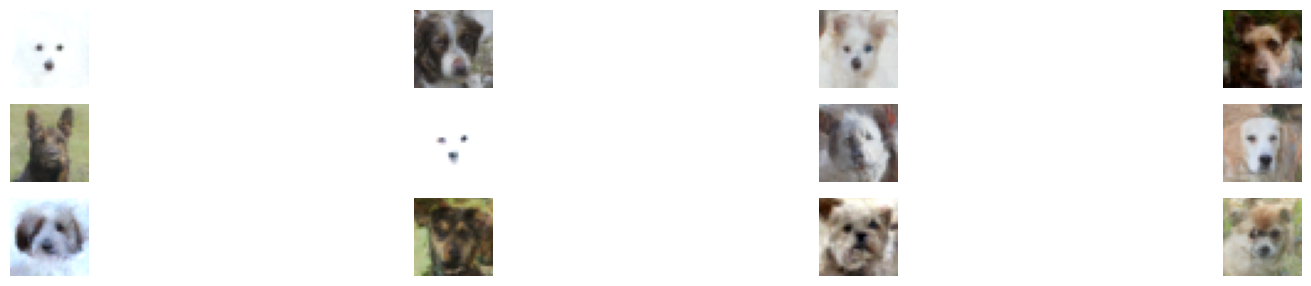

In [12]:
# Load last checkpoint
img_size = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

unet = UNet(device=device, image_size=img_size).to(device)
diffusion_model = DiffusionModel(unet, device=device, img_size=img_size)

checpoint = CheckpointManager('checkpoint_unet-diffusion-1')

optimizer = torch.optim.Adam(unet.parameters(), lr=3e-3)
mse_loss = nn.MSELoss()
checpoint.load_checkpoint(unet, optimizer)

samples = diffusion_model.sample(12)
images = samples.permute(0, 2, 3, 1) # [N, D, H, W] -> [N, H, W, D]
if type(images) == torch.Tensor and images.device.type != "cpu":
    images = images.to('cpu')
plt.figure(figsize=(20,12))
for i in range(images.shape[0]):
    plt.subplot(10,4, i+1)
    # print(predictions[i, :, :, :])
    plt.imshow(images[i, :, :, :])
    plt.axis('off')
# plt.show()